В категории обучения с учителем модели можно условно разделить на следующие основные типы:

- Линейные модели: линейная регрессия (для задачи регрессии) и логистическая регрессия (для задачи классификации) и производные от них.
- «Древесные» модели: дерево решений и производные от него. 
- Метрические алгоритмы: метод ближайших соседей и производные от него.
- Байесовские методы: метод наивного Байеса и производные от него.
- Ансамблевые методы: композиции из методов (бэггинг, стекинг, бустинг).

#### **Линейные модели** — это модели, отображающие зависимость целевого признака от факторов в виде линейной взаимосвязи.

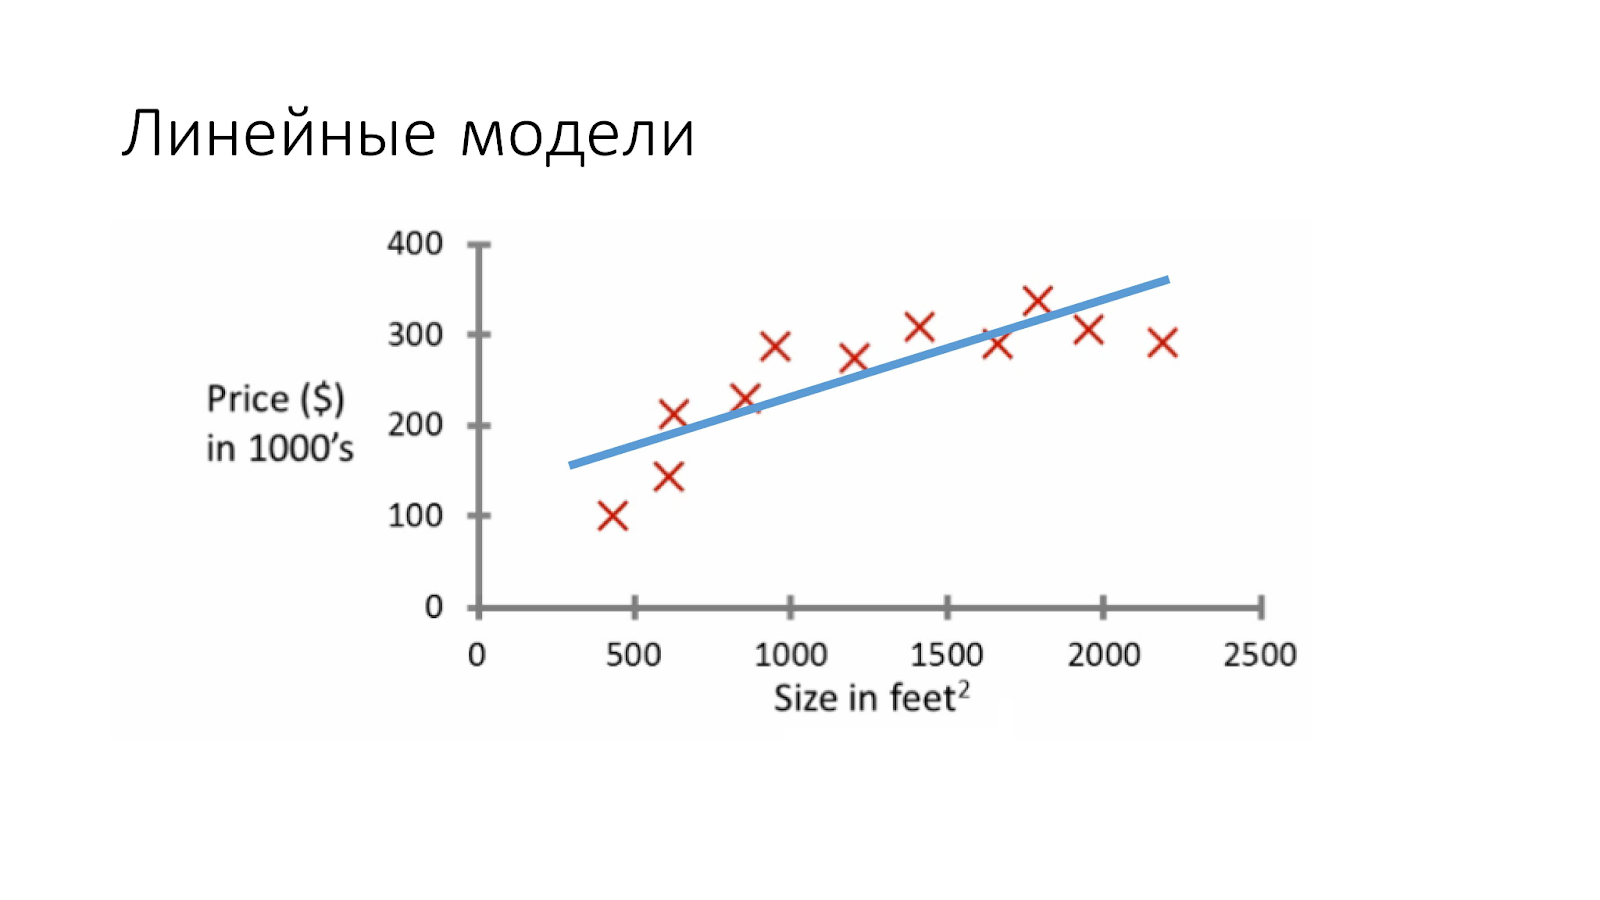

#### **Регрессия** — это класс задач обучения с учителем, когда по определённому набору признаков объекта необходимо предсказать числовую целевую переменную.

Цель обучения — построить модель, которая бы отражала зависимость между признаками и целевой числовой переменной.

#### **Линейная регрессия (Linear Regression)** — одна из простейших моделей для решения задачи регрессии. Главная гипотеза состоит в том, что рассматриваемая зависимость является линейной.

Остаётся вопрос: откуда взять коэффициенты, которые стоят при ?

Прямую же можно провести как угодно. Вот например несколько прямых, построенных с различными случайными коэффициентами:

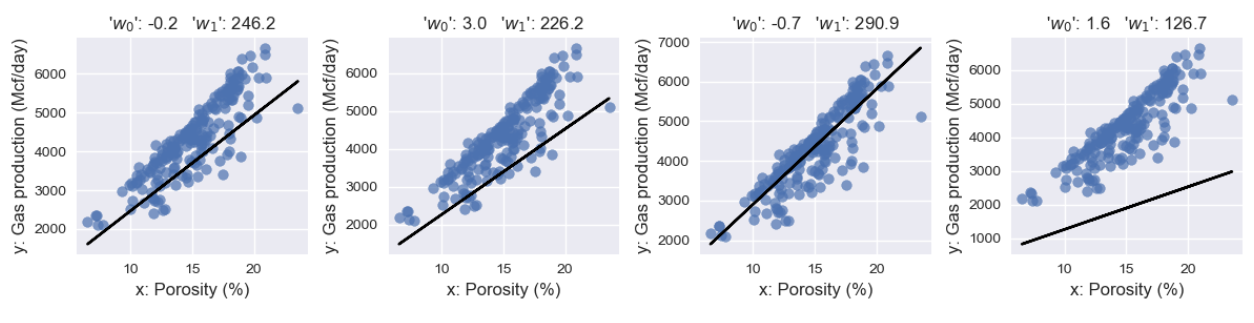

Какие параметры будут наилучшими?

Для ответа на этот вопрос давайте вспомним схему обучения моделей машинного обучения по принципу минимизации эмпирического риска, которую мы рассматривали в предыдущем модуле:


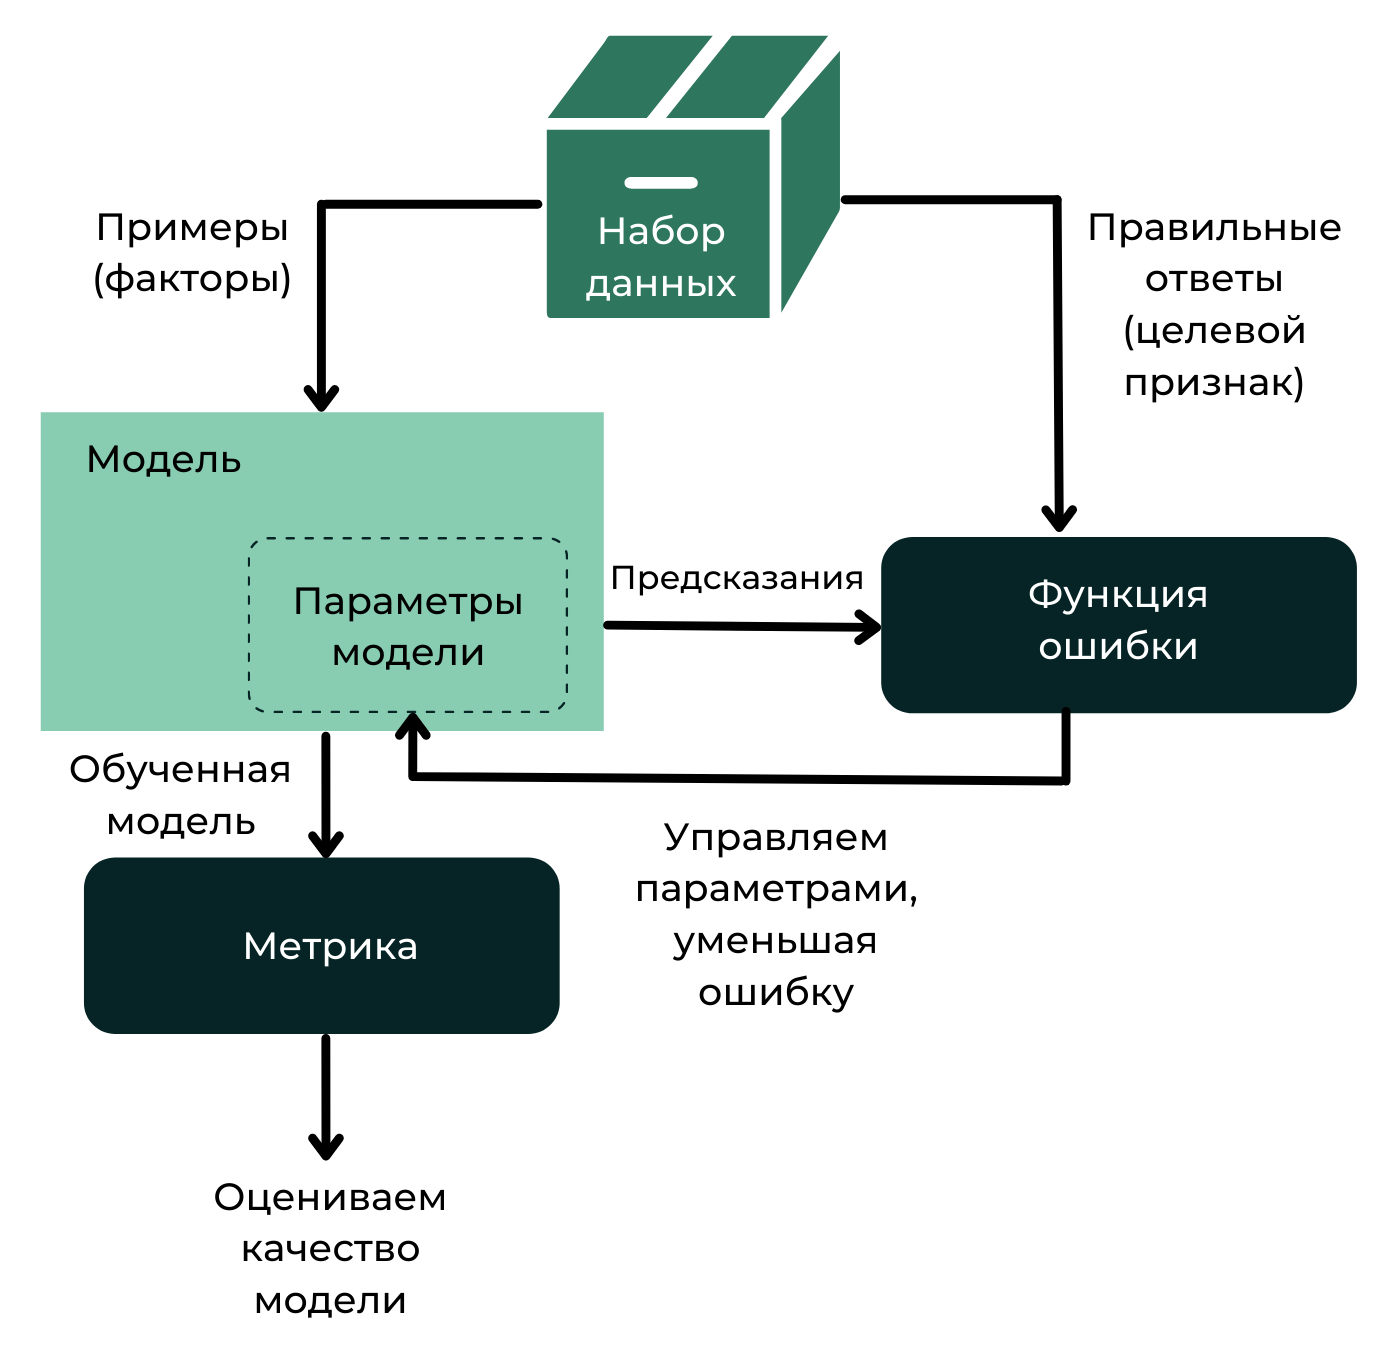

### АНАЛИТИЧЕСКОЕ РЕШЕНИЕ С ПОМОЩЬЮ NUMPY

Перейдём к практической части. Давайте научимся строить аналитическое решение линейной регрессии по МНК в Python.

Вот какие этапы нам предстоит пройти, чтобы построить свою модель:

- Загрузить данные и проанализировать датасет на предмет пропусков.
- Подготовить данные для подачи в модель: избавиться от пропусков, если они есть, и перекодировать категориальные признаки, если они представлены текстом.
- Построить модель. Будем строить несколько моделей линейной регрессии: первую — на одном признаке, вторую — на всех доступные признаках.
- Оценить качество модели.

In [192]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
import plotly
import plotly.express as px
%matplotlib inline
plt.style.use('seaborn-v0_8')

In [193]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
boston_data = pd.read_csv('data/housing.csv', header=None, delimiter=r"\s+", names=column_names)
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


- **CRIM** — уровень преступности на душу населения по городам.;
- **ZN** — доля земли под жилую застройку, разделённая на участки площадью более 25 000 кв. футов;
- **INDUS** — доля акров, которые принадлежат предприятиям, не связанным с розничной торговлей, на город;
- **CHAS** —фиктивная переменная реки Чарльз (1 — если участок прилегает к реке; 0 — в противном случае);
- **NOX** —концентрация оксидов азота (в десятимиллионных долях);
- **RM** —среднее количество комнат в доме;
- **AGE** —доля зданий, построенных до 1940 г. и занимаемых владельцами;
- **DIS** — взвешенные расстояния до пяти бостонских центров занятости;
- **RAD** — индекс доступности радиальных автомобильных дорог;
- **TAX** — полная ставка налога на имущество за каждые 10 000 долларов стоимости;
- **PTRATIO** — соотношение учеников и учителей по городам;
- **B** — 1000 (Bk — 0.63) , где Bk — доля граждан афроамериканского происхождения по городам;
- **LSTAT** — процент населения с низким статусом;
- **MEDV** — медианное значение стоимости домов, занимаемых владельцами, в тысячах долларов США (целевой признак).

In [194]:
corr_with_target = boston_data.corr()['MEDV'].abs().sort_values()
fig = px.bar(corr_with_target,text_auto=True)
fig.show()

In [195]:
X = boston_data[['LSTAT']] #матрица наблюдений
y = boston_data['MEDV'] #вектор правильных ответов
X.head()

,LSTAT
0,4.98
1,9.14
2,4.03
3,2.94
4,5.33


In [196]:
def linear_regression(X, y):
    #Создаём вектор из единиц
    ones = np.ones(X.shape[0])
    #Добавляем вектор к таблице первым столбцом
    X = np.column_stack([ones, X])
    #Вычисляем обратную матрицу Q
    Q = np.linalg.inv(X.T @ X)
    #Вычисляем вектор коэффициентов
    w = Q @ X.T @ y
    return w

Осталось только вызвать нашу функцию и передать в неё нашу таблицу примеров X и столбец правильных ответов y. Вычислим вектор параметров и выведем его на экран:



In [197]:
#Вычисляем параметры линейной регрессии
w = linear_regression(X, y)
#Выводим вычисленные значения параметров в виде вектора
print('Vector w: {}'.format(w))
#Выводим параметры с точностью до двух знаков после запятой
print('w0: {:.2f}'.format(w[0]))
print('w1: {:.2f}'.format(w[1]))
# Vector w: [34.55384088 -0.95004935]
# w0: 34.55
# w1: -0.95

Vector w: [34.55384088 -0.95004935]
w0: 34.55
w1: -0.95


In [198]:
#Задаём процент низкостатусного населения
x_example = 5.18 
#Делаем предсказание
y_predict = w[0] + w[1] * x_example
print('Predicted value: {:.2f}'.format(float(y_predict)))


Predicted value: 29.63


In [199]:
def plot_regression_2d(X, y_true, y_predict, xlabel='LSTAT', ylabel='MEDV'):
    fig, ax = plt.subplots(figsize=(8, 4)) #фигура + координатная плоскость
    ax.scatter(X, y_true, alpha=0.7, label='Sample data') #диаграмма рассеяния
    ax.plot(X, y_predict, color='black', label='Regression model') #линейный график
    ax.set_xlabel(xlabel) #название оси абсцисс
    ax.set_ylabel(ylabel) #название оси ординат
    ax.legend(facecolor='white', fontsize=11) #легенда

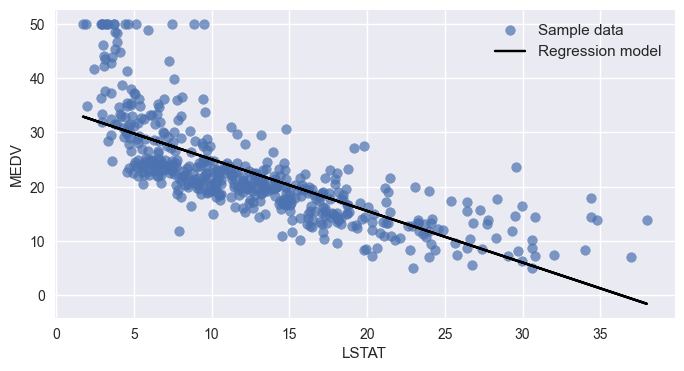

In [200]:
y_predict = w[0] + w[1] * X
#Строим визуализацию
plot_regression_2d(X, y, y_predict)

#визуализация метода наименьших квадратов регресии

In [201]:
df_xy = X.copy()
df_xy["MEDV"] = y
df_xy
figL = px.scatter(df_xy, x="LSTAT", y="MEDV", trendline="ols")
figL.show()

#### визуализация полиномиальной регресии

In [202]:
figP = px.scatter(df_xy, x="LSTAT", y="MEDV", trendline="lowess")
figP.show()

### АНАЛИТИЧЕСКОЕ РЕШЕНИЕ С ПОМОЩЬЮ SKLEARN

Алгоритм построения модели реализован в библиотеке машинного обучения sklearn и находится в модуле linear_model. Давайте импортируем этот модуль:

w0: 34.5538408793831
w1: [-0.95004935]


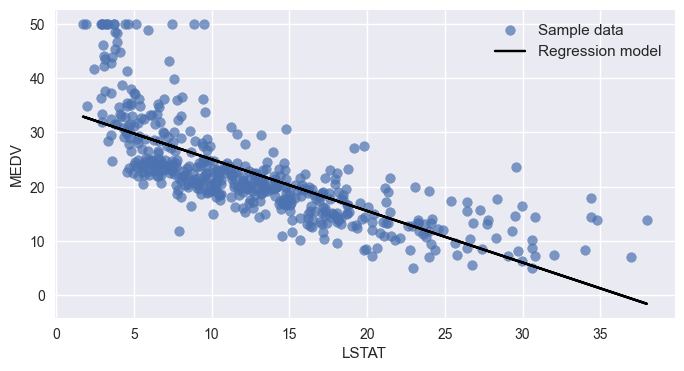

In [203]:
#Создаём объект класса LinearRegression
lr_lstat = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_lstat.fit(X, y)
 
print('w0: {}'.format(lr_lstat.intercept_)) #свободный член w0
print('w1: {}'.format(lr_lstat.coef_)) #остальные параметры модели w1, w2, ..., wm
 
# w0: 34.55384087938311
# w1: [-0.95004935]
#Предсказываем медианную цену для всех участков из набора данных
y_predict = lr_lstat.predict(X)
#Строим визуализацию
plot_regression_2d(X, y, y_predict)

Получаем тот же самый график, что мы видели ранее, когда реализовывали линейную регрессию вручную.

А что, если мы хотим построить линейную регрессию, используя всю предоставленную информацию, то есть все 13 признаков? Не проблема! Нужно только расширить матрицу наблюдений Х, добавив в неё остальные признаки и снова обучить модель LinearRegression.

Давайте выберем из таблицы boston все столбцы, исключая столбец с целевой переменной (MEDV). Полученную матрицу X и вектор правильных ответов y отправляем в метод fit(), чтобы произвести подгонку и найти параметры модели.

### линейная регресия для всех признаков

In [204]:
#Составляем список факторов (исключили целевой столбец)
features = boston_data.drop('MEDV', axis=1).columns
#Составляем матрицу наблюдений X и вектор ответов y
X = boston_data[features]
y = boston_data['MEDV']
#Создаём объект класса LinearRegression
lr_full = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_full.fit(X, y)

LinearRegression()

Для удобства составим DataFrame из коэффициентов   обученной модели, не забыв добавить к нему строку со свободным членом :

In [205]:
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': features, 'Coefficients': lr_full .coef_})
#Составляем строку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': lr_full .intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df)

,Features,Coefficients
0,CRIM,-0.108011
1,ZN,0.046420
2,INDUS,0.020559
3,CHAS,2.686734
4,NOX,-17.766611
5,RM,3.809865
6,AGE,0.000692
7,DIS,-1.475567
8,RAD,0.306049
9,TAX,-0.012335


Итак, мы получили таблицу с признаками из нашего набора данных и коэффициентами, которые им соответствуют.

Каждый из коэффициентов в модели показывает, на сколько в среднем (согласно модели) изменится медианная цена (в тысячах долларов) при увеличении параметра на единицу. Например, если уровень преступности увеличится на один пункт, то медианная цена зданий на участке упадёт на 0.1 тыс. долларов. А вот увеличение среднего количества комнат на участке (RM) на одну единицу повысит медианную цену на 3.8 тыс. долларов.

→ Свободный член (INTERCEPT) всё так же имитирует влияние внешних факторов и носит смысл «поправки» модели относительно медианной стоимости.

Итак, мы с вами построили две модели линейной регрессии: lr_lstat на одном признаке (LSTAT) и lr_full — на всех признаках в данных. Хотелось бы сравнить эти модели по их качеству. Может, нам достаточно только знаний о проценте низкостатусного населения, чтобы предсказать медианную цену?

Самая простая идея — визуализировать ошибки. Давайте построим коробчатые диаграммы ошибок моделей. Ошибки будем считать по формуле:

### Сравнивание методов

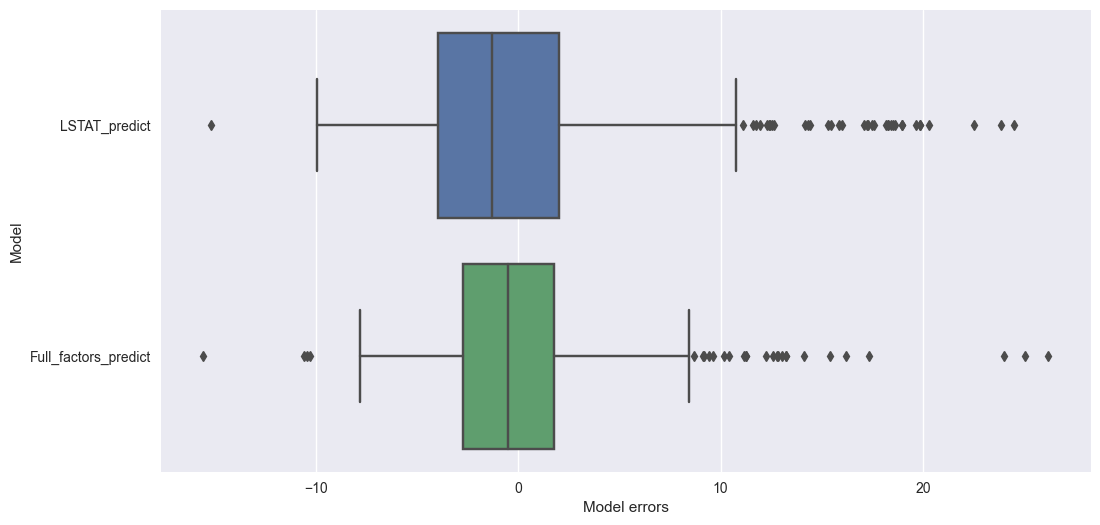

In [206]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура + координатная плоскость
#Ошибки модели на одном факторе LSTAT
y_errors_lstat = y - lr_lstat.predict(boston_data[['LSTAT']])
#Ошибки модели на всех факторах
y_errors_full = y - lr_full.predict(boston_data[features])
#Для удобства визуализации составим DataFrame из ошибок
errors_df = pd.DataFrame(
    {'LSTAT_predict': y_errors_lstat, 
     'Full_factors_predict': y_errors_full
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=errors_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

In [207]:
y_errors_lstat = y - lr_lstat.predict(boston_data[['LSTAT']])
#Ошибки модели на всех факторах
y_errors_full = y - lr_full.predict(boston_data[features])
#Для удобства визуализации составим DataFrame из ошибок
errors_df = pd.DataFrame(
    {'LSTAT_predict': y_errors_lstat, 
     'Full_factors_predict': y_errors_full
    }
)

figB = px.box(errors_df)
figB.show()

In [208]:
import plotly.graph_objects as go
fig = go.Figure()
# Use x instead of y argument for horizontal plot
fig.add_trace(go.Box(x=errors_df["Full_factors_predict"]))
fig.add_trace(go.Box(x=errors_df["LSTAT_predict"]))
fig.show()

In [209]:
b =   [0.35114,  0.00000,  7.38000,  0.00000,  0.49300,  6.04100, 49.90000,  4.72110,  5.00000,287.00000, 19.60000,396.90000,  7.70000]

In [210]:
bf = boston_data[features]
bf.loc[len(bf)] = b
a = lr_full.predict(bf)
a[-1]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8600\3038943391.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



22.869524474348104

In [211]:
df = pd.read_csv("data/50_Startups.zip")

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [213]:

figL = px.scatter(df, x="Marketing Spend", y="Profit", trendline="ols")
figL.show()

In [214]:
df = df.drop(columns=['State']) 
#Составляем список факторов (исключили целевой столбец)
featuresd = df.drop('Profit', axis=1).columns
#Составляем матрицу наблюдений X и вектор ответов y
X_1 = df[featuresd]
y_1 = df['Profit']
#Создаём объект класса LinearRegression
lr_full2 = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_full2.fit(X_1, y_1)

LinearRegression()

In [215]:
w_df = pd.DataFrame({'Features': featuresd, 'Coefficients': lr_full2 .coef_})
#Составляем строку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': lr_full2 .intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df)

,Features,Coefficients
0,R&D Spend,0.805715
1,Administration,-0.026816
2,Marketing Spend,0.027228
3,INTERCEPT,50122.192990


## РАСЧЁТ МЕТРИК НА PYTHON

Настало время проверить качество построенных нами ранее моделей линейной регрессии: lr_lstat и lr_full.

Весь набор функций для вычисления метрик в sklearn находится в модуле metrics. Давайте его импортируем:

### Функции, которые нам понадобятся:

- mean_absolute_error() — расчёт MAE;
- mean_squared_error() — расчёт MSE;
- ean_absolute_percentage_error() — расчёт MAPE;
- r2_score() — расчёт коэффициента детерминации .

В каждую из функций достаточно передать правильные ответы и предсказания, и функция вернёт рассчитанную метрику.

In [216]:
#Делаем предсказание по признаку LSTAT
y_predict_lstat = lr_lstat.predict(boston_data[['LSTAT']])
#Рассчитываем MAE
print('MAE score: {:.3f} thou. $'.format(metrics.mean_absolute_error(y, y_predict_lstat)))
#Рассчитываем RMSE
print('RMSE score: {:.3f} thou. $'.format(np.sqrt(metrics.mean_squared_error(y, y_predict_lstat))))
#Рассчитываем MAPE
print('MAPE score: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y, y_predict_lstat) * 100))
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict_lstat)))
 

MAE score: 4.505 thou. $
RMSE score: 6.203 thou. $
MAPE score: 21.352 %
R2 score: 0.544


роделываем ту же самую операцию для второй модели линейной регрессии, lr_full:

In [217]:
#Делаем предсказание по всем признакам
y_predict_full = lr_full.predict(boston_data[features])
#Рассчитываем MAE
print('MAE score: {:.3f} thou. $'.format(metrics.mean_absolute_error(y, y_predict_full)))
#Рассчитываем RMSE
print('RMSE score: {:.3f} thou. $'.format(np.sqrt(metrics.mean_squared_error(y, y_predict_full))))
#Рассчитываем MAPE
print('MAPE score: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y, y_predict_full) * 100))
#Рассчитываем коэффициент детерминации
print('R2 score: {:.3f}'.format(metrics.r2_score(y, y_predict_full)))

MAE score: 3.271 thou. $
RMSE score: 4.679 thou. $
MAPE score: 16.417 %
R2 score: 0.741


У вас есть истинные ответы y_true = [1.23, 2.35, 2.75] и предсказания модели y_pred = [1.01, 12.3, 2.74]. Посчитайте метрику RMSE, ответ округлите до двух знаков после точки-разделителя.

In [222]:
y_true32 = [1.23, 2.35, 2.75]
y_pred32 = [1.01, 12.3, 2.74]
print('RMSE score: {:.3f} thou. $'.format(round(np.sqrt(metrics.mean_squared_error(y_true32, y_pred32)),2)))

RMSE score: 5.750 thou. $


### Задание 3.3

Чему равен коэффициент детерминации на следующих данных?

Истинные ответы: y_true = [22.4, 20.6, 23.9, 22.0, 11.9]

Предсказанные ответы: y_pred = [20.5, 20.2, 20.3, 19.0, 11.0]

Ответ округлите до двух знаков после точки-разделителя.

In [224]:
y_true33 = [22.4, 20.6, 23.9, 22.0, 11.9]
y_pred33 = [20.5, 20.2, 20.3, 19.0, 11.0]
print('R2 score: {:.3f}'.format(round(metrics.r2_score(y_true33, y_pred33),2)))

R2 score: 0.710
